In [1]:
import torch
from src.module2graph import GraphInterperterWithGamma
from src.resnet18 import ResNet18
import numpy as np

import graphviz
import itertools
import copy

import networkx as nx
from tqdm.auto import tqdm

from numba import njit


In [2]:
resnet = ResNet18()
warp = GraphInterperterWithGamma(resnet)

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


In [3]:
named_dict = dict(resnet.named_modules())

for node in warp.graph.nodes:
    if node.op == 'call_module':
        pass
        # print('Norm', np.sqrt(sum([(p ** 2).sum().item() \
        #                            for p in named_dict[node.target].parameters()])))
    # print(node.op, node.name, node.args)
    # break
    

In [4]:
def module_to_graph(m: torch.nn.Module):
    warp = GraphInterperterWithGamma(m)
    named_dict = dict(m.named_modules())
    edges = [] # (from, to)
    weights = {'x': 0} # node: params
    for node in warp.graph.nodes:
        # no placeholder and call_mathod
        if node.op == 'call_module':
            n_params = sum([p.numel() for p in named_dict[node.target].parameters()])
            weights[node.name] = n_params
            assert len(node.args) == 1
            for arg in node.args:
                if type(arg) == torch.fx.Node:  # ignore constants
                    edges.append((arg.name, node.name))
        elif node.op == 'call_function':
            for arg in node.args:
                if type(arg) == torch.fx.Node:  # ignore constants
                    edges.append((arg.name, node.name))
            weights[node.name] = 0
        elif node.op == 'output':
            edges.append((node.args[0][0].name, node.name))
            weights['output'] = 0
            
    return edges, {'_'.join(k.split('.')): v for k, v in weights.items()}
    

In [5]:
edges, weights = module_to_graph(ResNet18())
# edges, weights
edges[:10], list(weights.items())[:10]

Using cache found in /Users/konstantinakovlev/.cache/torch/hub/pytorch_vision_v0.10.0


([('x', 'model_conv1'),
  ('model_conv1', 'model_bn1'),
  ('model_bn1', 'model_relu'),
  ('model_relu', 'model_maxpool'),
  ('model_maxpool', 'model_layer1_0_conv1'),
  ('model_layer1_0_conv1', 'model_layer1_0_bn1'),
  ('model_layer1_0_bn1', 'model_layer1_0_relu'),
  ('model_layer1_0_relu', 'model_layer1_0_conv2'),
  ('model_layer1_0_conv2', 'model_layer1_0_bn2'),
  ('model_layer1_0_bn2', 'add')],
 [('x', 0),
  ('model_conv1', 9408),
  ('model_bn1', 128),
  ('model_relu', 0),
  ('model_maxpool', 0),
  ('model_layer1_0_conv1', 36864),
  ('model_layer1_0_bn1', 128),
  ('model_layer1_0_relu', 0),
  ('model_layer1_0_conv2', 36864),
  ('model_layer1_0_bn2', 128)])

In [6]:
g = graphviz.Digraph('G', filename='hello.gv')

for src, dst in edges:
    g.edge(src, dst)

# g

In [7]:
# TODO: magnitude/Molchanov
edges_importance = [1] * len(edges)

<!-- ### Pseudocode

1. Consider the vertex that is one of the a childs of the built graph. Try to put it into each leayer where possible, minimizing the loss (the total weight of pruned edges). Note that the ansestors must be in the current or the previous layer. Also consider the case when the vertex is isolated, i.e. we create a new layer.

2. Repeat (1) until there exist vertices

 -->

In [8]:
# def get_subgraph(edges, weights, e_importance, memory=1e10):
#     # build a graph matrix
#     node_ids = {k: i for i, k in enumerate(weights)}
#     id_to_node = [node for _, node in enumerate(weights)]
#     m = np.zeros((len(node_ids), len(node_ids))).astype(np.int32)
#     assert len(edges) == len(e_importance)
#     for (src, dst), w in zip(edges, e_importance):
#         src_id, dst_id = node_ids[src], node_ids[dst]
#         m[src_id, dst_id] = w
    
#     node_to_layer = [-100] * len(node_ids)
#     layer_to_memory = [0]
#     node_to_layer[node_ids['x']] = 0
#     cur_layer = 0
#     for _ in range(m.shape[0]):
#         for node_id in range(m.shape[0]):  # node from the current/previous layer
#             if node_to_layer[node_id] != cur_layer and node_to_layer[node_id] != cur_layer - 1:
#                 continue
#             best_id, best_overflow_id = -1, -1
#             best_value, best_overflow_value = 1e9, 1e9
#             for to in range(m.shape[0]):  # candidate to be put
#                 if m[node_id, to] == 0 or node_to_layer[to] != -100:
#                     continue
#                 is_overflow = weights[id_to_node[to]] + layer_to_memory[cur_layer] > memory
#                 # try to add it to the current layer (TODO: try adding to all layers, which seems to be irrelevant)
#                 pruned_value = sum([m[j, to] for j in range(m.shape[0]) \
#                                     if m[j, to] != 0 and (node_to_layer[j] < cur_layer - 1 or node_to_layer[j] > cur_layer)])
#                 if is_overflow:
#                     if pruned_value < best_overflow_value:
#                         best_overflow_value = pruned_value
#                         best_overflow_id = to
#                 else:
#                     if pruned_value < best_value:
#                         best_value = pruned_value
#                         best_id = to
#             if best_id != -1:
#                 assert node_to_layer[best_id] == -100
#                 node_to_layer[best_id] = cur_layer
#                 layer_to_memory[cur_layer] += weights[id_to_node[best_id]]
#             elif best_id == -1 and best_overflow_id != -1:  # overflow
#                 cur_layer += 1
#                 node_to_layer[best_overflow_id] = cur_layer
#                 layer_to_memory.append(weights[id_to_node[best_overflow_id]])
#     # prune the edges
#     pruned_edges = []
#     pruned_value = 0
#     for i in range(m.shape[0]):
#         for j in range(m.shape[0]):
#             if abs(node_to_layer[i] - node_to_layer[j]) <= 1:
#                 continue
#             pruned_edges.append((id_to_node[i], id_to_node[j]))
#             pruned_value += m[i, j]
    
#     return {'layers': {id_to_node[i]: l for i, l in enumerate(node_to_layer)}, 'm': m, \
#             'pruned_edges': pruned_edges, 'pruned_value': pruned_value}
    

# get_subgraph(edges, {k: 1 for k in weights}, edges_importance, 5)['layers']

<!-- ### Conclusion

It seems that the problem is NP-hard. We need to come up with a new approach.
 -->

<!-- # The second attempt

Consider the following heuristic

1. Top sort (v_i, v_j) => i < j

2. for k in {n, ..., 1}

Consider 2 cases:

a) put v_k into the layer of its nearest child + prune some edges

b) put vk into a new layer => 

Consider all subsets of outcoming edges. We instantly identify a layer given a subset. So, we aggregate this layer with the answer of the nearest child to v_k
 -->

In [9]:
# from collections import defaultdict
 
# #Class to represent a graph
# class Graph:
#     def __init__(self,vertices):
#         self.graph = defaultdict(list) #dictionary containing adjacency List
#         self.V = vertices #No. of vertices
 
#     # function to add an edge to graph
#     def addEdge(self,u,v):
#         self.graph[u].append(v)
 
#     # A recursive function used by topologicalSort
#     def topologicalSortUtil(self,v,visited,stack):
 
#         # Mark the current node as visited.
#         visited[v] = True
 
#         # Recur for all the vertices adjacent to this vertex
#         for i in self.graph[v]:
#             if visited[i] == False:
#                 self.topologicalSortUtil(i,visited,stack)
 
#         # Push current vertex to stack which stores result
#         stack.insert(0,v)
 
#     # The function to do Topological Sort. It uses recursive
#     # topologicalSortUtil()
#     def topologicalSort(self):
#         # Mark all the vertices as not visited
#         visited = [False]*self.V
#         stack =[]
 
#         # Call the recursive helper function to store Topological
#         # Sort starting from all vertices one by one
#         for i in range(self.V):
#             if visited[i] == False:
#                 self.topologicalSortUtil(i,visited,stack)
#         return stack

    
# g = Graph(6)
# g.addEdge(5, 2)
# g.addEdge(5, 0)
# g.addEdge(4, 0)
# g.addEdge(4, 1)
# g.addEdge(2, 3)
# g.addEdge(3, 1)
 
# g.topologicalSort()

In [10]:
# def powerset(iterable):
#     """
#     powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
#     """
#     xs = list(iterable)
#     # note we return an iterator rather than a list
#     return itertools.chain.from_iterable(itertools.combinations(xs, n) for n in range(1, len(xs) + 1))



# def get_subgraph_top_sort(edges, weights, edge_importance, memory):
#     # build a graph matrix
#     node_ids = {k: i for i, k in enumerate(weights)}
#     id_to_node = [node for _, node in enumerate(weights)]
#     id_to_weight = [weights[n] for n in id_to_node]
#     m = np.zeros((len(node_ids), len(node_ids))).astype(np.int32)
#     assert len(edges) == len(edge_importance)
#     for (src, dst), w in zip(edges, edge_importance):
#         src_id, dst_id = node_ids[src], node_ids[dst]
#         m[src_id, dst_id] = w
    
#     # top sort
#     g = Graph(len(node_ids))
#     for i in range(m.shape[0]):
#         for j in range(m.shape[1]):
#             if m[i, j] != 0:
#                 g.addEdge(i, j)
#     top_sort = g.topologicalSort()
    
#     # node_to_layer = [-100] * len(node_ids)
#     # node_to_layer[top_sort[-1]] = 0  # put the output node
#     # layer_to_mem = [id_to_node[top_sort[-1]]]
#     node_to_layers = np.ones((len(node_ids), len(node_ids))).astype(np.int32) * (-100)  # ans for each v ->
#     node_to_layers[top_sort[-1], top_sort[-1]] = 0
#     dp = [1e9] * len(node_ids)  # total pruned weight
#     dp[top_sort[-1]] = 0
    
#     num_succ = 1
    
#     for i in range(len(node_ids) - 2, -1, -1):
#         v = top_sort[i]
#         # print(v, id_to_node[v])
#         # a) put v to the nearest layer
#         # a_success = False
#         # for j in range(i + 1, len(node_ids)):
#         #     if node_to_layers[top_sort[j], top_sort[j]] == -100:
#         #         continue
#         #     is_overflow = sum([id_to_weight[k] for k in range(m.shape[0]) if node_to_layers[top_sort[j], k] == \
#         #                        node_to_layers[top_sort[j], top_sort[j]]]) >= memory
#         #     if m[v, top_sort[j]] != 0 and not is_overflow:
#         #         # TODO: update dp
#         #         node_to_layers[v] = node_to_layers[top_sort[j]]
#         #         node_to_layers[v, v] = node_to_layers[v, top_sort[j]]
#         #         a_success = True
#         #         num_succ += 1
#         #         # print([k for k in range(node_to_layers[v].shape[0]) if node_to_layers[v, k] != -100])
#         #         break
#         # assert a_success  # attention
#         # if a_success:
#         #     continue
        
#         # b) put v to a new layer and take a subset of children
#         childs = [k for k in range(m.shape[0]) if m[v, k] != 0]
#         for c_subset in powerset(childs):
#             print(c_subset)
#             if sum([id_to_weight[k] for k in c_subset]) >= memory:
#                 continue
#             nearest_next_candidates = [k for k in range(max(c_subset) + 1, m.shape[0]) if m[max(c_subset), k] != 0]
#             if len(nearest_next_candidates) == 0:
#                 pruned_value = 0
#                 if pruned_value < dp[v]:
#                     dp[v] = pruned_value
#                     node_to_layers[v, v] = 0  # the very last layer
#                     node_to_layers[v, np.array(c_subset)] = 0
#                 continue
#             nearest_next_child = min(nearest_next_candidates)
#             next_layer_ids = node_to_layers[nearest_next_child][node_to_layers[nearest_next_child] == \
#                                                                node_to_layers[nearest_next_child, nearest_next_child]]
#             pruned_value = sum([m[k, l] for k in range(v, nearest_next_child) for l in range(m.shape[0]) \
#                                 if m[k, l] != 0 and (k not in c_subset or (l not in childs and l not in next_layer_ids))])
#             if pruned_value + dp[nearest_next_child] < dp[v]:
#                 dp[v] = pruned_value + dp[nearest_next_child]
#                 node_to_layers[v] = node_to_layers[nearest_next_child]
#                 cur_layer = node_to_layers[v].max()
#                 node_to_layers[v, np.array(childs)] = cur_layer + 1
#                 node_to_layers[v, v] = cur_layer + 1
                
#     return {'node_to_layers': node_to_layers, 'dp': dp, 'num_success': num_succ,
#             'ans': node_to_layers[node_ids['x']]}
            
        
        
    

In [11]:
# get_subgraph_top_sort(edges, {k: 1 for k in weights}, edges_importance, 10000)

## The second attenmp

1. Find all (sample) topological sorts

https://www.geeksforgeeks.org/all-topological-sorts-of-a-directed-acyclic-graph/

2. Apply greedy dynamic programming to find a monotonous solution

3. Postprocess a graph: remove all nodes that are unreacheble from "x".


In [12]:
DG = nx.DiGraph(edges)
all_sorts = list(nx.all_topological_sorts(DG))
len(all_sorts)

9261

In [13]:
# @njit
def dp_for_top_sort(edges, weights, e_importance, top_sort_str, memory=1e10):
    node_ids = {k: i for i, k in enumerate(weights)}
    id_to_node = [node for _, node in enumerate(weights)]
    top_sort = np.array([node_ids[n] for n in top_sort_str])
    assert top_sort[-1] == node_ids['output']
    assert top_sort[0] == node_ids['x']
    assert top_sort.shape[0] == len(node_ids)
    m = np.zeros((len(node_ids), len(node_ids))).astype(np.int32)
    id_to_weight = np.array([weights[n] for n in id_to_node])
    assert len(edges) == len(e_importance)
    for (src, dst), w in zip(edges, e_importance):
        src_id, dst_id = node_ids[src], node_ids[dst]
        m[src_id, dst_id] = w
        
    node_to_layers = np.ones((len(node_ids), len(node_ids))).astype(np.int32) * (-100)  # ans for each v ->
    node_to_layers[top_sort[-1], top_sort[-1]] = 0
    dp = [1e9] * len(node_ids)
    dp[top_sort[-1]] = 0
    for i in range(len(node_ids) - 2, -1, -1):
        v = top_sort[i]
        for j in range(i, len(node_ids)):  # the last node of the first layer (starting from v)
            if id_to_weight[top_sort[i: j + 1]].sum() > memory:
                continue
            if j == len(node_ids) - 1:
                dp[v] = 0
                node_to_layers[v, top_sort[i:]] = 0
                continue
            v_j = top_sort[j + 1]
            next_layer_ids = [] if j + 1 >= len(node_ids) else \
            [k for k in range(m.shape[0]) if node_to_layers[v_j, k] == node_to_layers[v_j, v_j]]
            pruned_value = sum([m[top_sort[k], l] for k in range(i, j + 1) for l in next_layer_ids if m[top_sort[k], l] != 0])
            if dp[v_j] + pruned_value <= dp[v]:
                dp[v] = dp[v_j] + pruned_value
                node_to_layers[v] = node_to_layers[v_j]
                node_to_layers[v, top_sort[i:j + 1]] = node_to_layers[v].max() + 1
                
    # prune restricted edges (TODO: also prune unreacheble nodes)
    ans = node_to_layers[node_ids['x']]
    pruned_edges_ids = [(i, j) for i in range(m.shape[0]) for j in range(m.shape[0]) \
                    if m[i, j] != 0 and abs(ans[i] - ans[j]) > 1]
    pruned_edges = [(id_to_node[i], id_to_node[j]) for i, j in pruned_edges_ids]
    pruned_value = sum([m[i, j] for i, j in pruned_edges_ids])
    
    reach_ids = [set() for _ in range(len(node_ids))]
    for i in range(len(node_ids) - 1, -1, -1):
        v = top_sort[i]
        reach_ids[v].add(v)
        for k in range(i + 1, m.shape[0]):
            v_c = top_sort[k]
            if m[v, v_c] != 0 and (v, v_c) not in pruned_edges_ids:
                reach_ids[v] |= reach_ids[v_c]
    conn_g = top_sort[-1] in reach_ids[top_sort[0]]
                
    return {'node_to_layer': {id_to_node[i]: ans.max() - l for i, l in enumerate(ans)},
            'pruned_value': pruned_value, 'pruned_edges': pruned_edges,
            'connected_graph': conn_g}


# find the best solution
best_pruned = 1e10
for s in tqdm(all_sorts):
    res = dp_for_top_sort(edges, {k: 1 for k in weights}, edges_importance, s, 10)  # for mem=8 the computation takes time
    if res['connected_graph'] == True and best_pruned > res['pruned_value']:
        best_pruned = res['pruned_value']
    if best_pruned == 0:
        print(res)
        break


  0%|          | 0/9261 [00:00<?, ?it/s]

{'node_to_layer': {'x': 0, 'model_conv1': 0, 'model_bn1': 0, 'model_relu': 0, 'model_maxpool': 0, 'model_layer1_0_conv1': 0, 'model_layer1_0_bn1': 0, 'model_layer1_0_relu': 0, 'model_layer1_0_conv2': 0, 'model_layer1_0_bn2': 0, 'add': 1, 'model_layer1_0_relu_1': 1, 'model_layer1_1_conv1': 1, 'model_layer1_1_bn1': 1, 'model_layer1_1_relu': 1, 'model_layer1_1_conv2': 1, 'model_layer1_1_bn2': 1, 'add_1': 1, 'model_layer1_1_relu_1': 2, 'model_layer2_0_conv1': 2, 'model_layer2_0_bn1': 2, 'model_layer2_0_relu': 2, 'model_layer2_0_conv2': 2, 'model_layer2_0_bn2': 2, 'model_layer2_0_downsample_0': 2, 'model_layer2_0_downsample_1': 2, 'add_2': 2, 'model_layer2_0_relu_1': 3, 'model_layer2_1_conv1': 3, 'model_layer2_1_bn1': 3, 'model_layer2_1_relu': 3, 'model_layer2_1_conv2': 3, 'model_layer2_1_bn2': 3, 'add_3': 3, 'model_layer2_1_relu_1': 4, 'model_layer3_0_conv1': 4, 'model_layer3_0_bn1': 4, 'model_layer3_0_relu': 4, 'model_layer3_0_conv2': 4, 'model_layer3_0_bn2': 4, 'model_layer3_0_downsample

In [14]:
## A synthetic U-net test

g = graphviz.Digraph()

edges_ex = [('x', '1'), ('1', '2'), ('2', '3'), ('3', '4'), ('4', 'output'), \
         ('1', 'output'), ('2', '4')]

weights_ex = {key: 1 for key in set(edges_ex[i][j] for i in range(len(edges_ex)) for j in range(2))}
weights_ex['2'] = weights_ex['4'] = 0.5
weights_ex['3'] = 2
edges_importance_ex = [1] * len(edges_ex)
edges_importance_ex[-2] = 10
edges_importance_ex[-1] = 5

for (src, dst), w in zip(edges_ex, edges_importance_ex):
    g.edge(src, dst, label=str(w))


g_nx_ex = nx.DiGraph(edges_ex)
all_sorts_ex = list(nx.all_topological_sorts(g_nx_ex))
print('All sorts', len(all_sorts_ex))
print('-' * 20)
dp_for_top_sort(edges_ex, {k: 1 for k in weights_ex}, edges_importance_ex, all_sorts_ex[0], 3)

# OK, the result is optimal

All sorts 1
--------------------


{'node_to_layer': {'x': 0, 'output': 2, '4': 1, '3': 1, '1': 0, '2': 1},
 'pruned_value': 10,
 'pruned_edges': [('1', 'output')],
 'connected_graph': True}

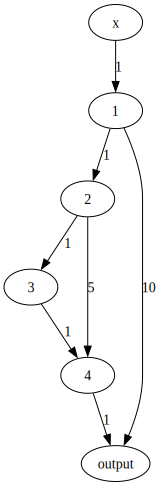

In [15]:
g

In [16]:
## A synthetic Res-Net test

g = graphviz.Digraph()

edges_ex = [('x', '1'), ('1', '2'), ('2', '3'), ('3', '5'), ('5', 'output'), ('1', '4'), ('4', '5')]

weights_ex = {key: 1 for key in set(edges_ex[i][j] for i in range(len(edges_ex)) for j in range(2))}
edges_importance_ex = [1] * len(edges_ex)

for (src, dst), w in zip(edges_ex, edges_importance_ex):
    g.edge(src, dst, label=str(w))


g_nx_ex = nx.DiGraph(edges_ex)
all_sorts_ex = list(nx.all_topological_sorts(g_nx_ex))
print('All sorts', len(all_sorts_ex))
print('-' * 20)
dp_for_top_sort(edges_ex, {k: 1 for k in weights_ex}, edges_importance_ex, all_sorts_ex[2], 4)

# OK, the result is optimal

All sorts 3
--------------------


{'node_to_layer': {'x': 0,
  'output': 1,
  '4': 0,
  '3': 1,
  '1': 0,
  '5': 1,
  '2': 0},
 'pruned_value': 0,
 'pruned_edges': [],
 'connected_graph': True}

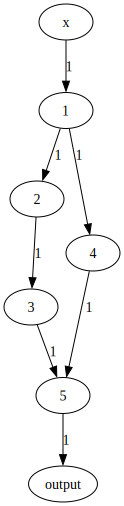

In [17]:
g